In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

**Metrics** in machine learning are needed to evaluate the quality of a model's performance, to understand how well the model has memorized patterns from the training sample.  

Today we continue to look at metrics for the **classification task**. For this task, we want our models to predict the correct object class label as often as possible.

<img src='https://static.javatpoint.com/tutorial/machine-learning/images/classification-algorithm-in-machine-learning.png' width=600>


The accuracy metric has a couple of problems:
- The metric is biased on samples with class imbalance
- It is impossible to give weights for different errors

So one wants to introduce a metric that sidesteps these problems.

## Data

Let's remember what mistakes were made with the credit scoring model.

Class 0 marks clients who will not repay the loan, and class 1 marks clients who will.
The sample has no class imbalance, 5 objects with class 0 and 5 with class 1.

In [2]:
clients = [0, 0, 0, 0, 0,
           1, 1, 1, 1, 1]
first_model_pred = [0, 0, 1, 1, 1,
                    1, 1, 1, 1, 1]
second_model_pred = [0, 0, 0, 0, 0,
                     1, 1, 0, 0, 0]


df = pd.DataFrame({
    'clients': clients,
    'first_model': first_model_pred,
    'second_model': second_model_pred
})

df

,clients,first_model,second_model
0,0,0,0
1,0,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,1,1,1
6,1,1,1
7,1,1,0
8,1,1,0
9,1,1,0


We got two models with different errors.

In [3]:
# Let's see if the models are working correctly
df['first_model_right'] = df['clients'] == df['first_model']
df['second_model_right'] = df['clients'] == df['second_model']

Let's consider class 1 as **target**, i.e. we will consider quality metrics relative to the first class.  

In the situation when the model predicts class 1, we will say that the model *performed*, since it predicted the target class.   
And in the situation when the model predicts 0 class, we will say that the model *did not work*, i.e. it *missed* the object, did not see the target class in it.

In [4]:
# Let's output the errors of the first model
df[~df['first_model_right']][['clients', 'first_model']]

,clients,first_model
2,0,1
3,0,1
4,0,1


In these errors, the first model approved a loan to customers who would not repay it. For zero (non-target class), the first (target class) was predicted, so it *failed*.  
This error is called a *false positive* or **False Positive**.

In [5]:
# Let's output the errors of the second model
df[~df['second_model_right']][['clients', 'second_model']]

,clients,second_model
7,1,0
8,1,0
9,1,0


It's the other way around. In these errors, the second model did not approve the loan to those clients who could pay for it. The model responds to objects with the first (target class) class with a null, i.e. it *skips* the objects, does not respond to them.

This error is called *false skip* or **False Negative**. The model did not give loans to people who were able to repay everything.

In addition to errors, there are also good triggers when a model responds to class 1 with class 1:

In [6]:
# Let's look at situations where the model answers 1 class correctly
df[(df['second_model_right']) & (df['clients'])][['clients', 'second_model']]

,clients,second_model
5,1,1
6,1,1


This correct behavior is called *true triggering* or **True Positive**. The model gives credit to the right people.

And the second good situation, with true skips, is when the model responds to 0 class with zero class:

In [7]:
# Let's look at the situations when the model responds correctly to 0 class
df[(df['second_model_right']) & ~(df['clients'])][['clients', 'second_model']]

,clients,second_model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


This correct behavior is called *true omission* or **True Negative**. The model does not give credit to bad customers.

## Confusion Matrix

We'll formalize everything into a matrix:

|  <empty>   | $$y = 1$$ | $$y = 0$$ |
--- | --- | ---
| __$$a(x) = 1$$__  |  True Positive TP    |  False Positive  FP   |
| __$$a(x) = 0$$__ |   False Negative FN    |   True Negative TN   |


The matrix has the true answers on the top and the algorithm's answers on the left. When the algorithm assigns an object to class "1", we say that it *works*, and when it assigns it to "0", we say that it *misses*.
- If the algorithm worked (predicted 1) and the object really belongs to class "1", we get True Positive (**True Positive, TP**) - ALL RIGHT
- If the algorithm worked (predicted 1), but the object does not belong to class "1", it is a false positive (**False Positive, FP**) - ERROR.
- If the algorithm misses an object (predicted 0) and its true class is "1", it is a false pass/false negative (**False Negative, FN**) - ERROR
- If the algorithm misses an object (predicted 0) and the true class of the object is "0", it is a true skip (**True Negative, TN**) - ALL TRUE

We can construct this error matrix for our problem for the first model, it is available in `sklearn` in the `metrics` module and is called `confusion_matrix`.

In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df['clients'], df['first_model'])

array([[2, 3],
       [0, 5]])

But it is easy to get confused here where are the true values, where are the model predictions, where is class zero and where is class one, so it is better to visualize the error matrix via heatmap.

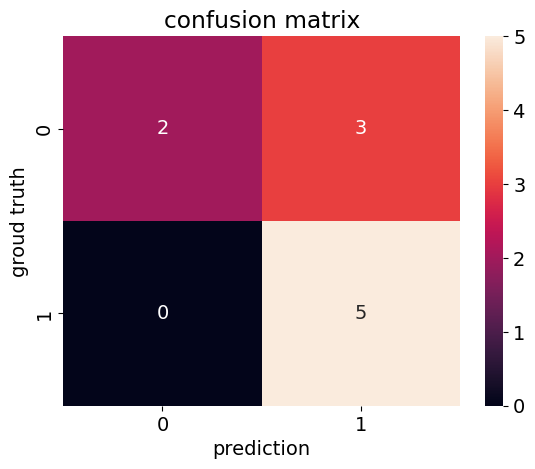

In [9]:
cm = confusion_matrix(df['clients'], df['first_model'])
sns.heatmap(cm, annot=True)

plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('groud truth');

And now we see that we have 2 pieces of TN, 5 pieces of TP, and 3 pieces of FP errors, when the model responded to the true zero class with 1 class.

Two good metrics are based on these TP, TN, FP, FN - Precision and Recall.

**Precision** represents the *fraction of true positives* of the total number of positives. It shows how much confidence can be placed in the classification algorithm in the event of a trigger

$$precision(a, X) = \frac{TP}{TP+FP}.$$

**Recall** counts as *the fraction of objects true of class "1"* that the algorithm has assigned to that class

$$recall(a, X) = \frac{TP}{TP+FN},$$

here $TP+FN$ will be the whole list of objects of class "1".


The metrics can vary from 0 to 1, where 0 - the model never got it right, all its predictions are wrong, and 1 - the model predicted everything perfectly.

There is a very nice picture that can be used to demonstrate how the metrics for classification are calculated.  
- The left rectangular darkened area is the area of target objects, these are our customers with 1 class
- The right bright rectangular area is the area of irrelevant objects with a grade 0, where customers do not return loans to us
- What is highlighted in the circle - these are the objects on which the model worked, predicted the 1st class
- And anything not included in the circle are objects that the model missed.

<img src='https://hsto.org/webt/so/oy/7k/sooy7k2lckgmsla2lgugjlisvh8.png' width=700>

And now let's go through each metric individually.

## Precision

**Precision** is responsible for *classification purity*, calculated as true actuations divided by all actuations in general.

$$precision(a, X) = \frac{TP}{TP+FP}$$

Ideally, the denominator is equal to the numerator, in which case the metric will be equal to 1. The precision metric minimizes **False Positive** errors; it is good if there are no such errors at all, then only the objects we need will be classified as the target class.

Let's calculate the precision for the first class for the two models.

### First model

First by hand using the error matrix:

In [10]:
df[['clients', 'first_model']]

,clients,first_model
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [11]:
cm = confusion_matrix(df['clients'], df['first_model'])
tp = cm[1][1]
fp = cm[0][1]

precision_1_model = tp / (tp + fp)
precision_1_model

0.625

And now also with the `precision_score` function from `sklearn`.

In [12]:
from sklearn.metrics import precision_score

precision_score(df['clients'], df['first_model'])

0.625

The metric is 0.625, we correctly classified 5 objects, and we assigned a total of 8 objects to the first class, which gave us the value of $\frac{5}{8} = 0.625$

### Second model

First by hand using the error matrix:

In [13]:
df[['clients', 'second_model']]

,clients,second_model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,1,0
8,1,0
9,1,0


In [14]:
cm = confusion_matrix(df['clients'], df['second_model'])
tp = cm[1][1]
fp = cm[0][1]

precision_2_model = tp / (tp + fp)
precision_2_model

1.0

And now also with the `precision_score` function from `sklearn`.

In [15]:
from sklearn.metrics import precision_score

precision_score(df['clients'], df['second_model'])

1.0

The metric is equal to 1, we correctly classified two objects out of two that the model assigned to class 1, we get precision = $\frac{2}{2} = 1$.

Now the two models don't seem as similar as they were when calculating the accuracy metric, on the precision metric the second model wins because it has no *false positives* **False Positive**, the model only gives credits to verified people, so it has a very *clean* classification performance.

## Recall

Let's see how things are going with another metric.


**Recall** is responsible for the *number of classifications*, calculated as true actuations divided by the objects of the target class.


$$recall(a, X) = \frac{TP}{TP+FN}$$


Ideally, when the denominator is equal to the numerator, in this case the metric will be equal to 1. The recall metric minimizes **False Negative** errors, it is good when there are no such errors, then we will find all possible objects of the target class and won't miss anyone.

Let's calculate the recall for the first class for the two models.

### First model

First by hand using the error matrix:

In [16]:
df[['clients', 'first_model']]

,clients,first_model
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [17]:
cm = confusion_matrix(df['clients'], df['first_model'])
tp = cm[1][1]
fn = cm[1][0]

recall_1_model = tp / (tp + fn)
recall_1_model

1.0

And now also with the `recall_score` function from `sklearn`.

In [18]:
from sklearn.metrics import recall_score

recall_score(df['clients'], df['first_model'])

1.0

The metric is equal to 1, we correctly assigned five objects out of five to class 1, that is, we found all the objects of the target class that we could, as a result we got a value equal to $\frac{5}{5} = 1$.

### Second model

First by hand using the error matrix:

In [19]:
df[['clients', 'second_model']]

,clients,second_model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,1,0
8,1,0
9,1,0


In [20]:
cm = confusion_matrix(df['clients'], df['second_model'])
tp = cm[1][1]
fn = cm[1][0]

recall_2_model = tp / (tp + fn)
recall_2_model

0.4

And now also with the `recall_score` function from `sklearn`.

In [21]:
from sklearn.metrics import recall_score

recall_score(df['clients'], df['second_model'])

0.4

The metric is equal to 0.4, we correctly assigned only two objects to the target class out of five possible ones, i.e. we made 3 false negative errors and got the recall metric equal to $\frac{2}{5} = 0.4$.

Once again the models don't seem to be the same, their recall metrics are very different, now the first model looks more favorable as it has no *false omissions* **False Negative**, the model gave loans to all verified people and left no one without money.

## Model Comparison

Let's compare our two models on class 1 prediction at 10 sites:

|  <empty>   | first model | second model |
--- | --- | ---
| __precision__  |  0.625    |  1   |
| __recall__ |   1    |   0.4   |

One has a good recall and the other has a good precision, so now we can look at the bank's strategy and decide which is more important:
- If the bank wants to make **more money**, then it is better to lend to *all* people who are able to pay it back, i.e. we are looking for a model with maximum *recall* - and this is the first model.
- If the bank wants to **lose less**, then it's better to lend *only* to reliable people, which means looking for the model with the best *precision* - which is the second model.


## Summary

<table>

<tr>
<td>
Metric
</td>

<td>
Formula
</td>

<td>
Value ranges
</td>

<td>
Ideal value
</td>
</tr>

<tr>
<td>
Precision
</td>

<td>
$$precision = \frac{TP}{TP + FP}$$

</td>

<td>
[0, 1]
</td>

<td>
1
</td>
</tr>
<td>
Recall
</td>

<td>
$$recall = \frac{TP}{TP + FN}$$

</td>

<td>
[0, 1]
</td>

<td>
1
</td>
</tr>

<table>